# Multi-label Classification with OneVsRest Strategy

## Loading the Movie summaries

# Task 1

In [2]:
import pandas as pd
import json
from itertools import chain
from collections import Counter
!pip install fasttext

# load metadata
header_info = ['id', 'id2', 'name', 'date', 'revenue', 'runtime', 'lang', 'countries', 'genres']
meta_data = pd.read_csv('movie.metadata.tsv', sep='\t', names=header_info, header=None)

# we are mainly interested in the genre column, therefore we reduce to id and genre
movie_gen = meta_data.loc[:,['id', 'genres']]
# the genre column is a dictionary format, hence transform to list
movie_gen['genres'] = [list(json.loads(g).values()) for g in movie_gen['genres']]
print(movie_gen[:3])

# load movie plots
movie_plots = pd.read_csv("plot_summaries.txt", sep='\t', names=['id', 'plot'], header=None)
print(movie_plots[:3])

     |████████████████████████████████| 68 kB 4.4 MB/s 
  Using cached pybind11-2.9.1-py2.py3-none-any.whl (211 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3131652 sha256=70a858095c4bec2afef5bace0e4b618bcca178673a1d35496ba71573183453ab
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext
         id                                             genres
0    975900  [Thriller, Science Fiction, Horror, Adventure,...
1   3196793   [Mystery, Biographical film, Drama, Crime Drama]
2  28463795                             [Crime Fiction, Drama]
         id                                               plot
0  23890098  Shlykov, a hard-working taxi driver and Lyosha...
1  31186339  The nation of Panem consists of a wealthy Capi...
2  20663735  Poovalli Induchoodan  is sentenced for six yea...


## Assessing label frequency

[('Drama', 34007), ('Comedy', 16349), ('Romance Film', 10234), ('Black-and-white', 9094), ('Action', 8798), ('Thriller', 8744), ('Short Film', 8141), ('World cinema', 7155), ('Crime Fiction', 6948), ('Indie', 6897), ('Documentary', 5630), ('Horror', 5280), ('Silent film', 5250), ('Adventure', 4963), ('Family Film', 4598), ('Action/Adventure', 4561), ('Comedy film', 4362), ('Musical', 4160), ('Animation', 3534), ('Romantic drama', 3372), ('Mystery', 3195), ('Science Fiction', 3052), ('Fantasy', 2820), ('Romantic comedy', 2680), ('War film', 2652), ('Japanese Movies', 2322), ('Western', 2226), ('Crime Thriller', 2122), ('Period piece', 1758), ('Comedy-drama', 1720)]


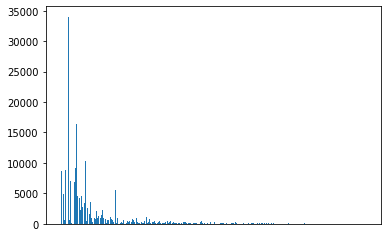

----------------------------------------------------
Number of labels that only occur once or twice: 25
----------------------------------------------------
         id  ...                                             genres
0  23890098  ...                              [Drama, World cinema]
1  31186339  ...  [Action/Adventure, Science Fiction, Action, Dr...
2  20663735  ...                [Musical, Action, Drama, Bollywood]

[3 rows x 3 columns]


In [3]:
import matplotlib.pyplot as plt

# bring the frequency of genres in a Counter format
genres_freq = Counter(chain.from_iterable(movie_gen['genres']))
print(genres_freq.most_common(30))
plt.bar(*zip(*dict(genres_freq).items()))
plt.xticks([])
plt.show()
print('----------------------------------------------------')

# compute how many genres occur only once or twice
rare = [k for k,v in genres_freq.items() if v < 3]
print("Number of labels that only occur once or twice: "+ str(len(rare)))
print('----------------------------------------------------')

# remove rare genres
movie_gen['genres'] = [[g for g in gen_list if g not in rare] for gen_list in movie_gen['genres']]
movie_gen.dropna()

# merge the plot texts (X) and the genres (y)
movie_data = pd.merge(movie_plots, movie_gen, on='id')
print(movie_data[:3])

## Cleaning the movie summaries(text)


In [4]:
import re

def clean_text(text):
    """
    Return clean version of the text
    """
    # Remove all non-letters and non-spaces except for hyphens and digits
    text = re.sub("[^0-9A-Za-z\- ]+", " ", text)
    # Remove all numbers except those attached to a word
    text = re.sub("(?<!\w)\d+", "", text)
    # Remove all hyphens except between two words
    text = re.sub("-(?!\w)|(?<!\w)-", "", text)
    # Remove multiple spaces and lowercase everything
    text = " ".join(text.split())
    text = text.lower()

    return text

movie_data['plot'] = movie_data['plot'].apply(clean_text)
print(movie_data['plot'][:5])

0    shlykov a hard-working taxi driver and lyosha ...
1    the nation of panem consists of a wealthy capi...
2    poovalli induchoodan is sentenced for six year...
3    the lemon drop kid a new york city swindler is...
4    seventh-day adventist church pastor michael ch...
Name: plot, dtype: object


## Binarization and Vectorization

In [5]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(movie_data['genres'])
y = multilabel_binarizer.transform(movie_data['genres'])
# TODO before binarization and after binarization


x_train, x_test, y_train, y_test = train_test_split(movie_data['plot'], y, test_size=0.2, random_state=13)

print('Example before binarization: ')
print(movie_data['genres'][7])

print('Example after binarization: ')
print(y[7])

Example before binarization: 
['Drama', 'Teen']
Example after binarization: 
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]


## Train a classifier with OneVsRest strategy

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=5000)
x_train = tfidf_vectorizer.fit_transform(x_train)
x_test = tfidf_vectorizer.transform(x_test)
# set number of iterations to 200 to ensure convergence
lr = LogisticRegression(max_iter=200, verbose=1)
ovr = OneVsRestClassifier(lr)

# fit the model on the training data
ovr.fit(x_train, y_train)

# predictions for test set
y_pred = ovr.predict(x_test)
# print(multilabel_binarizer.inverse_transform(y_pred)[7])

# compute F1-score
f1_score = f1_score(y_test, y_pred, average="micro")
print("Micro F1-score for logistic regression: "+ str(f1_score))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

Micro F1-score for logistic regression: 0.3126922288291983


# Task 2

# Multi-label classification using fastText

In [7]:
import fasttext
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(movie_data.drop(['id'], axis=1), test_size=0.2, random_state=13)


# EXERCISE Q1: fastText requires a special input format, namely that labels and text are concatenated separated by
# a new line (\n). Also, the labels should start and end with two underscores. Whitespaces in between should receive
# another symbol, e.g. a single underscore.
# Save two .txt files, one for the train data and one for the test data in the correct format.

with open('train.txt','w+', encoding="utf-8") as train_file:
    for i in train_df.index:
        labels = ''
        for genre in train_df['genres'][i]:
            labels = labels + '__label__' + genre.replace(' ', '_') + ' '
        line = labels + ' '+train_df['plot'][i]
        train_file.write(line+'\n')

with open('test.txt','w+', encoding="utf-8") as test_file:
    for i in test_df.index:
        labels = ''
        for genre in test_df['genres'][i]:
            labels = labels + '__label__'+ genre.replace(' ', '_') + ' '
        line = labels + ' '+test_df['plot'][i]
        test_file.write(line+'\n')

# EXERCISE Q2:
# Equipped with the correct format, train a fasttext model with the following parameters: learning rate=0.7, epoch=30,
# wordNgrams=3, bucket=20000, loss='ova'
# test the model with the parameters k=-1 and threshold 0.5
# what are your results?

model = fasttext.train_supervised(input='train.txt', lr=0.7, epoch=30, wordNgrams=3, bucket=20000, loss='ova')


# EXERCISE Q3:
# Change the threshold - What happens? Why?
test_num, precision, recall = model.test('test.txt', k=-1, threshold=0.7)
f_score = (2*precision*recall)/(precision+recall)
print(f_score)

0.34367325836887685


# Task 3

In [8]:
# using diff learning rate(0.5)
model1 = fasttext.train_supervised(input='train.txt', lr=0.5, epoch=30, wordNgrams=3, bucket=20000, loss='ova')

test_num, precision, recall = model1.test('test.txt', k=-1, threshold=0.7)
f_score = (2*precision*recall)/(precision+recall)
print(f_score)

0.33716357916812306


In [9]:
# using diff wordNgrams value(4)
model2 = fasttext.train_supervised(input='train.txt', lr=0.7, epoch=30, wordNgrams=4, bucket=20000, loss='ova')

test_num, precision, recall = model2.test('test.txt', k=-1, threshold=0.7)
f_score = (2*precision*recall)/(precision+recall)
print(f_score)

0.3266151655086099


In [10]:
# using diff epoch value(40)
model3 = fasttext.train_supervised(input='train.txt', lr=0.7, epoch=40, wordNgrams=3, bucket=20000, loss='ova')

test_num, precision, recall = model3.test('test.txt', k=-1, threshold=0.7)
f_score = (2*precision*recall)/(precision+recall)
print(f_score)

0.3472682470898123


# **Observation:**

Decrease in Learning rate and increase in wordNgrams --- Decrease the F_score  
Increase in Epoch value --- Increase the F_score  

# Task 4

# Multi-label classification with Keras

In [11]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MultiLabelBinarizer
from keras.models import Sequential
from keras.layers import Dense, Embedding, GlobalMaxPool1D
from keras.metrics import AUC, Accuracy


mlb = MultiLabelBinarizer()
mlb.fit(movie_data['genres'])
y = mlb.transform(movie_data['genres'])

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(movie_data['plot'])
sequences = tokenizer.texts_to_sequences(movie_data['plot'])
x = pad_sequences(sequences, maxlen=200)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

num_classes = len(y_train[0])
max_words = len(tokenizer.word_index) + 1

model = Sequential()
model.add(Embedding(max_words, 20, input_length=200))
model.add(GlobalMaxPool1D())
model.add(Dense(num_classes, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC()])
trained = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_split=0.2)
metrics = model.evaluate(x_test, y_test)
print(model.metrics_names[1], metrics[1])

Epoch 1/20
845/845 [==============================] - 12s 9ms/step - loss: 0.1641 - auc: 0.6893 - val_loss: 0.0432 - val_auc: 0.8995
Epoch 2/20
845/845 [==============================] - 7s 9ms/step - loss: 0.0410 - auc: 0.9007 - val_loss: 0.0409 - val_auc: 0.9016
Epoch 3/20
845/845 [==============================] - 7s 9ms/step - loss: 0.0402 - auc: 0.9050 - val_loss: 0.0405 - val_auc: 0.9061
Epoch 4/20
845/845 [==============================] - 7s 9ms/step - loss: 0.0399 - auc: 0.9076 - val_loss: 0.0403 - val_auc: 0.9091
Epoch 5/20
845/845 [==============================] - 7s 9ms/step - loss: 0.0398 - auc: 0.9088 - val_loss: 0.0403 - val_auc: 0.9092
Epoch 6/20
845/845 [==============================] - 7s 9ms/step - loss: 0.0398 - auc: 0.9093 - val_loss: 0.0402 - val_auc: 0.9089
Epoch 7/20
845/845 [==============================] - 7s 9ms/step - loss: 0.0397 - auc: 0.9097 - val_loss: 0.0402 - val_auc: 0.9090
Epoch 8/20
845/845 [==============================] - 8s 9ms/step - loss: 0